In [1]:
import feather
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Defining helper functions

In [2]:
def load_data(fname, label):
    """Load features and labels file and join them together using user_id_hash"""
    df = feather.read_dataframe(fname)
    df['user_id_hash'] = df['user_id_hash'].astype('category')
    labels = pd.read_csv('labels.csv', usecols=['user_id_hash', label])
    df = df.merge(labels, how='left', on='user_id_hash')
    df[label].fillna(0, inplace=True)
    df = df.dropna(axis=0)
    return df

In [3]:
def stratified_data_split(feature_columns:list, label_column:str):
    """Splitting train and test set using stratified sampling given that our data is highly skewed"""
    return train_test_split(df[feature_columns],
                            df[label_column], 
                            stratify=df[label_column], random_state=1)

## For 14 days

In [4]:
df = load_data(fname='Data/features_before_14_v7.feather', label='label_14')

X_train, X_val, y_train, y_val = stratified_data_split(feature_columns=df.columns[1:-1], 
                                                       label_column='label_14')

In [6]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, subsample=0.5)
gbm = xgb.fit(X_train, y_train)

In [7]:
gbm_pred_train = gbm.predict_proba(X_train)
gbm_pred_val = gbm.predict_proba(X_val)
roc_auc_score(y_true=y_val, y_score=gbm_pred_val[:,1])

0.9726315865072896

In [8]:
X_all = feather.read_dataframe('Data/features_v7.feather').set_index('user_id_hash')
X_all = X_all[X_train.columns]

In [9]:
pred_all_14 = gbm.predict_proba(X_all)


## For 7 days

In [13]:
df = load_data(fname='Data/features_before_7_v7.feather', label='label_7')

X_train, X_val, y_train, y_val = stratified_data_split(feature_columns=df.columns[1:-1], 
                                                       label_column='label_7')

In [14]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators=100, max_depth=12, learning_rate=0.1, subsample=0.5, nthread=-1)
gbm = xgb.fit(X_train, y_train)

In [15]:
gbm_pred_train = gbm.predict_proba(X_train)
gbm_pred_val = gbm.predict_proba(X_val)

# validation AUC
roc_auc_score(y_true=y_val, y_score=gbm_pred_val[:,1])

0.9766617619222078

In [18]:
# training AUC
roc_auc_score(y_true=y_train, y_score=gbm_pred_train[:,1])

0.9976292211015328

In [16]:
X_all = feather.read_dataframe('Data/features_v7.feather').set_index('user_id_hash')
X_all = X_all[X_train.columns]
pred_all_7 = gbm.predict_proba(X_all)


In [19]:
X_all['user_purchase_binary_14_days'] = pred_all_14[:, 1]
X_all['user_purchase_binary_7_days'] = pred_all_7[:, 1]

In [20]:
# for ft, score in sorted(zip(X_train.columns, gbm.feature_importances_), key=lambda x: x[1], reverse=True):
#     print(ft, score)
    

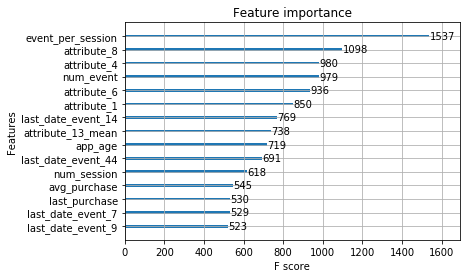

In [21]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(gbm, ax=None, show_values=True, max_num_features=15)

## Saving prediction

In [22]:
submission = pd.read_csv('sample_submission_2.csv', usecols=['user_id_hash'], index_col='user_id_hash')

submission = submission.join(X_all[['user_purchase_binary_7_days', 'user_purchase_binary_14_days']], how='left')
submission.fillna(0.0023675038, inplace=True)

submission.to_csv('submission7.csv')